In [1]:
"""
This notebook takes in ngram time series data produced from a MR job
The assumed format is:

2	(2013-01-01 ,#dead)

ie.. word \t (date, term)

We parse this data and fit a linear trend model to each term
Through clever use of interaction terms in statsmodels we can do this in 1 shot

"""
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import gzip
import string
import re
from time import time
import os.path
from datetime import datetime
import shutil

##read in stopwrods file
stopwords=[]
with open('stopwords.txt', 'r') as stop_fn:
    for line in stop_fn:
       stopwords.append(line.strip().replace('"', '')) 
print("read in {} stopwords".format(len(stopwords)))
print(stopwords)

read in 175 stopwords
['x', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', 'her', 'hers', 'herself', 'it', 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'would', 'should', 'could', 'ought', "i'm", "you're", "he's", "she's", "it's", "we're", "they're", "i've", "you've", "we've", "they've", "i'd", "you'd", "he'd", "she'd", "we'd", "they'd", "i'll", "you'll", "he'll", "she'll", "we'll", "they'll", "isn't", "aren't", "wasn't", "weren't", "hasn't", "haven't", "hadn't", "doesn't", "don't", "didn't", "won't", "wouldn't", "shan't", "shouldn't", "can't", 'cannot', "couldn't", "mustn't", "let's", "that's", "who's", "what's", "here's", "there's", "when's", "where's", "why's", "how's", 'a', 'an',

In [2]:
t0=time()
line_num=0
data_for_df=[]
with open('/mnt/snelson/word_time_series/unzipped_word_time_series.txt', 'r') as f:
    for line in f:
        line_num+=1
        try:
            num_test_recs=1000
            #if line_num>num_test_recs:
            #    break
            data=line.split('\t')
            count=data[0]
            mytuple=[x.translate(None, ")(").strip() for x in re.split(',', data[1], maxsplit=1)]
            dt, term=mytuple
            dt=dt.strip()
            term=term.strip()
            count=int(count)
            ## check if date is correct
            pattern=re.compile('20[0-9]{2}-[0-9]{2}-[0-9]{2}')
            if term not in stopwords and len(mytuple)==2 and len(dt)==10 and pattern.search(dt):
                dt_list = dt.split("-")
                guess_date = int(int(dt_list[1])-1)*31 + int(dt_list[2])
                #dt_days=(datetime.strptime(dt, '%Y-%m-%d') - datetime.strptime('2013-01-01', '%Y-%m-%d')).days
                data_for_df.append([guess_date, term, count])
        except:
            print("error on line {}: {}".format(line_num, line))
            continue

#pickle data for later use
#df.to_pickle('df.pkl')
t1=time()
tot=(t1-t0)/60
print("time to run test data:{} minutes".format(tot))
print("estimated time to run total:{} minutes".format(tot*(15061489/num_test_recs) ))

time to run test data:2.87869764964 minutes
estimated time to run total:43356.0653012 minutes


In [3]:
## convert lsit of lists to a df
df=pd.DataFrame(data_for_df, columns=['dt', 'term', 'count'])
#df.dt=pd.to_datetime(df.dt, format='%Y-%m-%d')
df=df.drop_duplicates()
df=df.groupby(['dt', 'term'])['count'].sum().reset_index()
print(df)

           dt                      term  count
0           1                "addition"      1
1           1             "addition" in      1
2           1         "addition" in the      1
3           1                 "bedford"      1
4           1             "bedford" wtf      1
5           1          "bedford" wtf is      1
6           1                    "beer"      2
7           1                   "drunk"      1
8           1              "drunk" they      1
9           1          "drunk" they are      1
10          1               "ennn-ybody      1
11          1           "ennn-ybody can      1
12          1       "ennn-ybody can see      1
13          1                    "face"      1
14          1                 "face" on      1
15          1             "face" on abc      1
16          1                   "house"      1
17          1              "house" sets      1
18          1           "house" sets up      1
19          1                "most-used      1
20          1

In [4]:
#pickle data for later use
#df.to_pickle('df.pkl')

In [5]:
## formatting
print(df.columns)
print(df.head(n=5))
print(df.shape)
print(df.dtypes)

Index([u'dt', u'term', u'count'], dtype='object')
   dt               term  count
0   1         "addition"      1
1   1      "addition" in      1
2   1  "addition" in the      1
3   1          "bedford"      1
4   1      "bedford" wtf      1
(15003920, 3)
dt        int64
term     object
count     int64
dtype: object


In [6]:
#number of unique terms in the data
unique_terms=df.term.unique()
print(unique_terms)
print(len(unique_terms))


['"addition"' '"addition" in' '"addition" in the' ..., 'zzz zzzy tonight'
 'zzzy' 'zzzy tonight']
5895375


In [7]:
# terms with more than 500 mentions
term_count=df.groupby(['term'])['count'].sum()
print(len(term_count[term_count>500]))
print(term_count[term_count>500])
print(term_count[term_count>500].index[:5].values)

3876
term
"beer"                588
#acbw                 769
#beer               36294
#beer #cheers         601
#beer #craftbeer      679
#cheers              1248
#craftbeer           4858
#craftbeer #beer      595
#drunk                521
#food                 794
#friends              611
#goodtimes            558
#homebrew             545
#merica               574
#microbrew            556
#party                534
#photo                698
#summer               716
#sun                  543
#wine                 987
#winning              577
#yelp                 575
$1                   1327
$10                   859
$2                   1359
$3                   1186
$4                    750
$5                   1602
&                   73354
&amp                49172
                    ...  
you need             2198
you need a            503
you need to           657
you on                530
you say               777
you see               581
you should           1673
yo

In [8]:
## filter down data set to only include terms with more than 500 mentions -- ~4000 unique terms
## 1.3M rows of data
df2=df[df.term.isin(term_count[term_count>500].index.values)]
print(len(df2))
print(len(df2.term.unique()))


1244866
3876


In [9]:
## filter to terms with more than 30 days of data
## would be nice if this was consecutive days 
num_days_by_term=df2.groupby(['term']).size()
num_days_by_term.sort(ascending=False)
print(num_days_by_term)



term
i drink                    365
store                      365
drinking                   365
sitting                    365
having a                   365
drinking a                 365
drinking a beer            365
sit                        365
is a                       365
drinking beer              365
have to                    365
drinks                     365
since                      365
show                       365
drunk                      365
beer of                    365
shot                       365
is beer                    365
be a                       365
early                      365
shit                       365
set                        365
eat                        365
eating                     365
beer belly                 365
sleep                      365
having a beer              365
so i                       365
sorry                      365
still                      365
                          ... 
april                      163
the

In [10]:
## run regression on top 100 terms due to memory issues
df3=df2[df2.term.isin(num_days_by_term[:1].index.values)]
print(df3.shape)
print df3


(365, 3)
           dt     term  count
24647       1  i drink     12
67952       2  i drink      2
101922      3  i drink      9
139638      4  i drink      5
180796      5  i drink      7
221629      6  i drink      6
260258      7  i drink      3
296378      8  i drink     16
332013      9  i drink      5
367903     10  i drink      8
407308     11  i drink      7
450500     12  i drink     13
493142     13  i drink     12
531231     14  i drink      5
564722     15  i drink      6
599384     16  i drink      8
635939     17  i drink      9
676836     18  i drink      7
720883     19  i drink     12
765632     20  i drink      6
805683     21  i drink      9
839572     22  i drink      4
874078     23  i drink      5
911677     24  i drink      6
953600     25  i drink      7
999403     26  i drink     15
1042637    27  i drink      9
1079774    28  i drink      1
1114548    29  i drink      4
1152142    30  i drink      5
...       ...      ...    ...
13992092  343  i drink      3
1

In [13]:
## fit *ALL* models at once  using interaction terms
import statsmodels.api as sm
import statsmodels.formula.api as smf
t0=time()
results={}
for i in range(len(num_days_by_term.index)):
    df3=df2[df2.term==num_days_by_term.index[i]]
    results[i] = smf.ols(formula='count ~ C(term) + C(term)*dt', data=df3).fit()
t1=time()
print("running time:{}".format(t1-t0))


running time:395.565048933


In [32]:
## parse out results
def get_data(statistic='tval'):   
    if statistic=='tval':
        a=[results[i].tvalues['dt'] for i in results]
    else:
        a=[results[i].params['dt'] for i in results]
    b=num_days_by_term.index.values
    c=pd.DataFrame(zip(b,a), columns=['term', statistic])
    c=c.sort([statistic], ascending=False)
    print(c)
    return(c)
tval_data=get_data(statistic='tval')
coef_data=get_data(statistic='params')

                  term       tval
2344        right here  12.047207
2848    cold beer with  11.395926
3781              edge  10.855379
3792         sit right  10.795118
3794    sit right here  10.646001
2741    beer with your  10.563053
3796              pier  10.503302
1753       and drink a  10.321078
3662            sunset  10.295648
856          with your  10.099635
3780           name on  10.086425
3833          the edge   9.828029
3774         your name   9.823062
581            of this   9.748537
3137           license   9.351407
1117             on it   9.183810
3807        name on it   9.174629
3816               bid   8.850284
3839         disappear   8.753307
47        drink a beer   8.631148
998               type   8.625537
2343            county   8.550602
3822            #photo   8.381109
3847        the sunset   8.324239
3823      wine license   8.269661
3852           edge of   8.175358
1815            so i'm   7.913249
3853       on the edge   7.871482
3829       lic

In [34]:
#test plot
from matplotlib.backends.backend_pdf import PdfPages
def plotit(i, term):
    test=df2[df2.term==term]
    test1=pd.Series(data=test['count'].values, index=test['dt'])
    #test1.plot(title=term)
    plt.figure(); ax=test1.plot(title=term);
    ax.set_xlabel("day")
    ax.set_ylabel("mention count/day")
    pdf.savefig()
    #plt.savefig('./figs/{}.pdf'.format(i))
    plt.close()
    
##tvals
## can see this at http://data-science-6.gnip.com/~snelson/tval.pdf
plot_file='tval.pdf'
with PdfPages(plot_file) as pdf:
    for i, term in enumerate(tval_data.term.values[:200]):
        plotit(i, term)
shutil.copy(plot_file, '/home/snelson/public_html')

##coef file
## can see this at http://data-science-6.gnip.com/~snelson/coef.pdf
plot_file='coef.pdf'
with PdfPages(plot_file) as pdf:
    for i, term in enumerate(coef_data.term.values[:200]):
        plotit(i, term)
shutil.copy(plot_file, '/home/snelson/public_html')

,term,tval
2344,right here,12.047207
2848,cold beer with,11.395926
3781,edge,10.855379
3792,sit right,10.795118
3794,sit right here,10.646001
2741,beer with your,10.563053
3796,pier,10.503302
1753,and drink a,10.321078
3662,sunset,10.295648
856,with your,10.099635


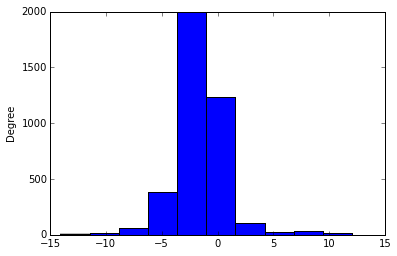

In [71]:
#histogram of 4000k t-values
tval_data['tval'].plot(kind='hist')
tval_data[tval_data.tval>2]

In [116]:
## pull out sig terms and compute distances of the TS
sig_terms=tval_data[tval_data.tval>2] #244 terms
sig_ts=df2[df2.term.isin(sig_terms.term)]
sig_ts2=pd.pivot_table(sig_ts, index='term', values='count', columns='dt')
print("dimensions before dropping missing values:{}".format(sig_ts2.shape))
sig_ts3=sig_ts2.fillna(0)
#sig_ts3=sig_ts2.dropna(axis=0) ## drop terms with missing vals
print("dimensions after dropping missing values:{}".format(sig_ts3.shape))
sig_ts3

dimensions before dropping missing values:(143, 365)
dimensions after dropping missing values:(143, 365)


dt,1,2,3,4,5,6,7,8,9,10,...,363,364,365,366,367,368,369,370,371,372
term,,,,,,,,,,,,,,,,,,,,,
#photo,0,0,0,0,0,0,0,0,0,0,...,9,10,13,20,8,6,15,10,10,10
#wine,2,1,1,4,2,2,1,2,4,1,...,3,9,4,4,3,0,2,5,2,4
- drinking,0,0,0,0,0,2,0,0,0,0,...,16,13,20,35,16,14,20,26,10,19
- drinking a,0,0,0,0,0,0,0,0,0,0,...,12,11,17,28,15,9,9,23,7,15
20,3,7,3,5,4,4,2,6,2,4,...,4,11,11,9,5,8,5,8,7,11
@beermenus,0,1,2,4,3,1,3,1,2,2,...,0,0,0,0,0,0,0,0,0,0
@boulevard_beer,2,1,1,1,0,0,1,0,0,5,...,4,3,3,4,3,3,1,5,0,5
@youtube,0,2,2,5,3,5,2,7,3,2,...,4,7,2,4,2,4,3,3,5,4
added,0,3,7,6,6,3,3,6,3,3,...,5,6,15,2,6,8,16,10,5,11


In [117]:
## hierarchical clustering
from sklearn.metrics.pairwise import pairwise_distances
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
dist=pairwise_distances(sig_ts3)
Z=linkage(dist, method='single')
fn='dendrogram.pdf'
with PdfPages(fn) as pdf:
    plt.figure(figsize=(30, 15), tight_layout=True)
    dend=dendrogram(Z, orientation='right', labels=sig_terms.term.values, leaf_font_size=0.01, count_sort=True)
    pdf.savefig(orientation='landscape')
    plt.close()
shutil.copy(fn, '/home/snelson/public_html')